In [1]:
% t_colorThresholdEllipsoidFit
%
% This tutorial demonstrates routines for fitting a threshold ellipsoid to
% data.  See 
%   Poirson AB, Wandell BA, Varner DC, Brainard DH. 1990. Surface characterizations
%   of color thresholds. J. Opt. Soc. Am. A 7: 783-89
% For a discussion of the fitting principles.
%
% See also t_colorThresholdEllipsoids

In [2]:
%% Clear and close
clear; close all;

% Turn off an irritating plot warning
s = warning('off','MATLAB:delaunay:DupPtsDelaunayWarnId');

In [3]:
%% Use parameters from the model of Poirson and Wandell (1996) to generate
% some simulated data.  See t_colorThresholdEllipsoids.
conditionStr = 'HT,cc';
theSf = 2;
[simulatedA,simulatedAinv,simulatedQ,theBgLMS] = PoirsonWandellEllipsoidParameters(conditionStr,theSf);

In [5]:
%% Generate some data to fit
%
% First we need to specify color directions for some simmulated
% measurements.  We'll do this in cone contrast space, which allows us
% to think a bit about reasonable directions.  The list below was just made
% up by hand.
testContrastDirections = [1 1 1 ; ...
    1 0 0 ; ...
    0 1 0 ; ...
    0 0 1 ; ...
    1 -1 0 ; ...
    1 0 -1 ; ...
    0 1 -1 ; ...
    ]';
    
% Reflect specified directions through the origin, to get more directions
% and make the shape of the threshold contour easy to see/fit.  Also
% convert cone contrast directions to excitation directions, since the
% Poirson-Wandell model parameters are specified to work on differences of
% excitations from the background.
testContrastDirections = [testContrastDirections -testContrastDirections];
testExcitationDirections = bsxfun(@times,testContrastDirections,theBgLMS);

In [6]:
% Generate the underlying ellipsoid that we simulated
nThetaEllipsoid = 50;
nPhiEllipsoid = 50;
xUnitSphere = UnitSphereGenerate(nThetaEllipsoid,nPhiEllipsoid);
xSimulatedEllipsoidExcitations = simulatedAinv*xUnitSphere;
xSimulatedEllipsoidContrasts =  bsxfun(@times,xSimulatedEllipsoidExcitations,1./theBgLMS);

% Find threshold for each direction, and convert back to contrast
thresholdExcitations = PointsOnEllipsoidFind(simulatedQ,testExcitationDirections);
thresholdContrasts =  bsxfun(@times,thresholdExcitations,1./theBgLMS);

% Add some noise to the length of each simulated threshold
thresholdNoiseFractionSd = 0.02;
for ii = 1:size(thresholdContrasts,2)
    noisyThresholdContrasts(:,ii) = thresholdContrasts(:,ii)*(1+normrnd(0,thresholdNoiseFractionSd));
end

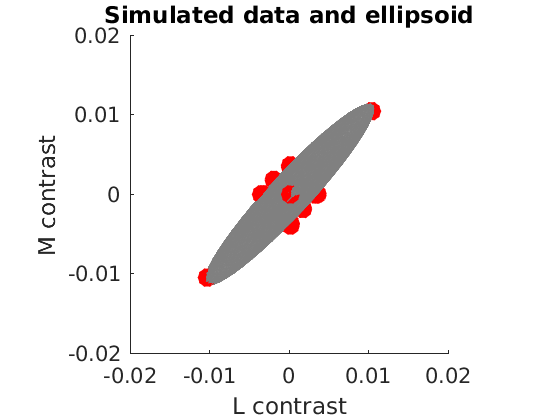

In [10]:
%% Plot the simulated threshold points and their generating ellipsoid
figure; clf; hold on; set(gca,'FontSize',10);
plot3(noisyThresholdContrasts(1,:),noisyThresholdContrasts(2,:),noisyThresholdContrasts(3,:),...
    'ro','MarkerSize',8,'MarkerFaceColor','r');
xCoords = squeeze(xSimulatedEllipsoidContrasts(1,:));
yCoords = squeeze(xSimulatedEllipsoidContrasts(2,:));
zCoords = squeeze(xSimulatedEllipsoidContrasts(3,:));
tri = delaunay(xCoords, yCoords, zCoords);
h = trisurf(tri, xCoords, yCoords, zCoords);
set(h,'FaceAlpha',0.1)
set(h,'EdgeColor',[0.5 0.5 0.5])
set(h,'FaceColor',[0.6 0.6 0.6]);
lighting phong;
xlim([-0.02 0.02]); ylim([-0.02 0.02]); zlim([-0.05 0.05]);
axis('square');
xlabel('L contrast'); ylabel('M contrast'); zlabel('S contrast');
title('Simulated data and ellipsoid','FontSize',10);

In [11]:
%% Fit the data with an ellipsoid
%
% And generate samples of the ellipsoid for plotting
[initialFitA,initialFitAinv,initialFitQ,initialFitEllParams] = EllipsoidFit(noisyThresholdContrasts);
xInitialFitEllipsoid = initialFitAinv*xUnitSphere;

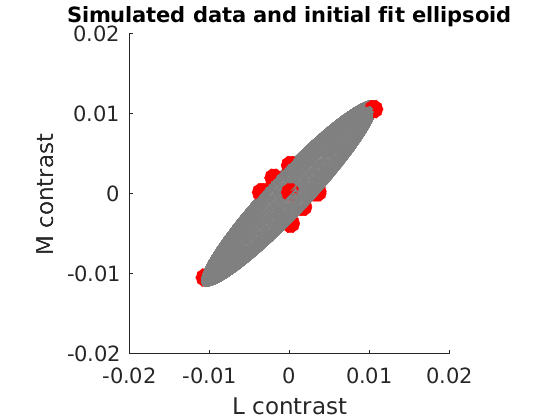

In [12]:
%% Plot the simulated threshold points and the initial fit ellipsoid in 3D cone contrast space
figure; clf; hold on; set(gca,'FontSize',10);
plot3(noisyThresholdContrasts(1,:),noisyThresholdContrasts(2,:),noisyThresholdContrasts(3,:),'ro','MarkerSize',8,'MarkerFaceColor','r');
xCoords = squeeze(xInitialFitEllipsoid(1,:));
yCoords = squeeze(xInitialFitEllipsoid(2,:));
zCoords = squeeze(xInitialFitEllipsoid(3,:));
tri = delaunay(xCoords, yCoords, zCoords);
h = trisurf(tri, xCoords, yCoords, zCoords);
set(h,'FaceAlpha',0.1)
set(h,'EdgeColor',[0.5 0.5 0.5])
set(h,'FaceColor',[0.6 0.6 0.6]);
lighting phong;
xlim([-0.02 0.02]); ylim([-0.02 0.02]); zlim([-0.05 0.05]);
axis('square');
xlabel('L contrast'); ylabel('M contrast'); zlabel('S contrast');
title('Simulated data and initial fit ellipsoid','FontSize',10);

In [13]:
%% Looking at the plot reveals that although the ellipsoid probably fits the data well,
% the data may not fully constrain the ellipsoid, depending on how it is aligned
% with the color directions sampled in the (simulated) measurments).  There
% is some run to run variability in this regard, depending on how the
% simulated measurement noise comes out on a given run.
%
% This is a typical experience in real experiments, where some sort of
% adaptive approach is needed to put the data where it constrains the
% model.  Here we'll do something simple, and use the inital fit to choose
% additional points more or less along the major axes of the ellipsoid that we found.
% We then interate on that a few times.
%
% One could get fancier about test direction selection. One might also want
% to add more points in other directions if one wanted to verify that the
% actual threshold surface is in fact well described by an ellipsoid.
fitA = initialFitA; fitAinv = initialFitAinv; fitQ = initialFitQ;
fitEllParams = initialFitEllParams;
perturbFractionSd = 0.1;
nIterations = 5;
for ii = 1:nIterations
    newTestExcitationDirections = [fitAinv*eye(3) -fitAinv*eye(3)];
    newTestExcitationDirections = newTestExcitationDirections + normrnd(0,perturbFractionSd*mean(abs(newTestExcitationDirections(:))),size(newTestExcitationDirections));
    newThresholdExcitations = PointsOnEllipsoidFind(simulatedQ,newTestExcitationDirections);
    newThresholdContrasts =  bsxfun(@times,newThresholdExcitations,1./theBgLMS);
    for ii = 1:size(newThresholdContrasts,2)
        newNoisyThresholdContrasts(:,ii) = newThresholdContrasts(:,ii)*(1+normrnd(0,thresholdNoiseFractionSd));
    end
    noisyThresholdContrasts = [noisyThresholdContrasts newNoisyThresholdContrasts];
    [fitA,fitAinv,fitQ,fitEllParams] = EllipsoidFit(noisyThresholdContrasts);
end
xFitEllipsoid = fitAinv*xUnitSphere;

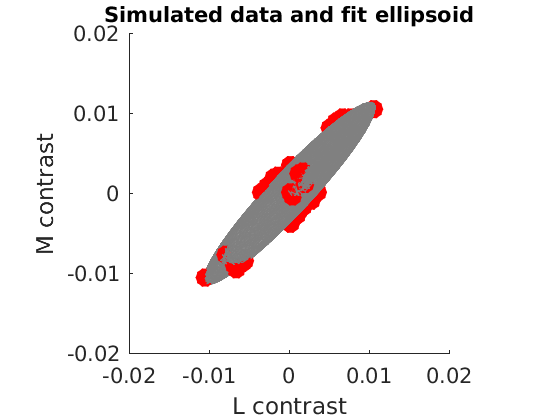

In [14]:
%% Replot with new data and new fit
%
% Usually this is a good resemblance to the simulated ellipsoid, although
% every once and a while the data may not quite constrain the fit.
figure; clf; hold on; set(gca,'FontSize',10);
plot3(noisyThresholdContrasts(1,:),noisyThresholdContrasts(2,:),noisyThresholdContrasts(3,:),'ro','MarkerSize',8,'MarkerFaceColor','r');
xCoords = squeeze(xFitEllipsoid(1,:));
yCoords = squeeze(xFitEllipsoid(2,:));
zCoords = squeeze(xFitEllipsoid(3,:));
tri = delaunay(xCoords, yCoords, zCoords);
h = trisurf(tri, xCoords, yCoords, zCoords);
set(h,'FaceAlpha',0.1)
set(h,'EdgeColor',[0.5 0.5 0.5])
set(h,'FaceColor',[0.6 0.6 0.6]);
lighting phong;
axis('square');
xlim([-0.02 0.02]); ylim([-0.02 0.02]); zlim([-0.05 0.05]);
xlabel('L contrast'); ylabel('M contrast'); zlabel('S contrast');
title('Simulated data and fit ellipsoid','FontSize',10);

In [15]:
%% Put warning state back
warning(s.state,s.identifier);